# Word2Vec之Skip-Gram模型实战-中文文本版

下面代码将用TensorFlow实现Word2Vec中的Skip-Gram模型。

> 使用的是爬取的某IT招聘网站的招聘信息训练词向量
1. 导包
2. 加载数据
3. 数据预处理
4. 数据采样
5. 训练数据构造
6. 网络的构建
7. 训练
8. 可视化

# 1 导入包

In [1]:
import time
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from collections import Counter

In [2]:
tf.__version__

'1.14.0'

# 2 加载数据

数据集使用的是爬取的某IT招聘网站的招聘信息，数据已经进行切词处理，2944万词。

In [5]:
with open('data/Javasplittedwords', encoding='utf-8') as f:
    text = f.read()

In [6]:
words=text.split(' ')

In [7]:
len(words)

8898942

# 3 数据预处理

数据预处理过程主要包括：

- 替换文本中特殊符号并去除低频词
- 对文本分词
- 构建语料
- 单词映射表

首先我们定义一个函数来完成前两步，即对文本的清洗和分词操作。

In [8]:
# 定义函数来完成数据的预处理
def preprocess(text, freq=50):
    '''
    对文本进行预处理
    
    参数
    ---
    text: 文本数据
    freq: 词频阈值
    '''
    # 对文本中的符号进行替换
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # 删除低频词，减少噪音影响
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > freq]

    return trimmed_words

上面的函数实现了替换标点及删除低频词操作，返回分词后的文本。

下面让我们来看看经过清洗后的数据:

In [17]:
# 清洗文本并分词
words = preprocess(text)
print(words[:20])

['熟练掌握', 'java', '熟悉', 'python', 'shell', '熟练使用', 'git', 'svn', '能够', '发现', '问题', '精准', '定位问题', '快速', '解决问题', '熟悉', 'jvm', 'jvm', '优化', '经验']


In [18]:
words.sort()

In [20]:
print(words[:100])

['20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁', '20岁']


有了分词后的文本，就可以构建我们的映射表。

In [24]:
# 构建映射表
vocab = set(words)

In [25]:
len(vocab)

6791

In [26]:
vocab_to_int = {word: index for index, word in enumerate(vocab)}

In [27]:
int_to_vocab = {index: word for index, word in enumerate(vocab)}

In [28]:
print("total words: {}".format(len(words)))
print("unique words: {}".format(len(set(words))))

total words: 8623686
unique words: 6791


整个文本中单词大约为800万的规模，词典大小为6000左右，这个规模对于训练好的词向量其实是不够的，但可以训练出一个稍微还可以的模型。

In [29]:
# 对原文本进行vocab到int的转换
int_words = [vocab_to_int[w] for w in words]

# 4 采样

我们知道`skip-gram`中，训练样本的形式是`(input word, output word)`，其中`output word`是`input word`的上下文。为了减少模型噪音并加速训练速度，我们在构造`batch`之前要对样本进行采样，剔除停用词等噪音因素。

对停用词进行采样，例如“你”， “我”以及“的”这类单词进行剔除。剔除这些单词以后能够加快我们的训练过程，同时减少训练过程中的噪音。

我们采用以下公式:
$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

其中$ t $是一个阈值参数，一般为1e-3至1e-5。  
$f(w_i)$ 是单词 $w_i$ 在整个数据集中的出现频次。  
$P(w_i)$ 是单词被删除的概率。

>这个公式和论文中描述的那个公式有一些不同

In [30]:
int_word_counts = Counter(int_words)

In [31]:
t = 1e-3 # t值
threshold = 0.7 # 剔除概率阈值

# 统计单词出现频次
int_word_counts = Counter(int_words)
total_count = len(int_words)
# 计算单词频率
word_freqs = {w: c/total_count for w, c in int_word_counts.items()}
# 计算被删除的概率
prob_drop = {w: 1 - np.sqrt(t / word_freqs[w]) for w in int_word_counts}
# 对单词进行采样
train_words = [w for w in int_words if prob_drop[w] < threshold]

In [32]:
drop_words=[int_to_vocab[w] for w in int_words if prob_drop[w] > threshold]

In [33]:
set(drop_words)

{'产品', '工作', '开发', '熟悉', '相关', '经验', '能力', '设计', '负责'}

上面的代码计算了样本中每个单词被删除的概率，并基于概率进行了采样，现在我们手里就拿到了采样过的单词列表。

In [34]:
len(int_words)

8623686

In [19]:
len(train_words)

7536370

从上面数据可以看到，我们本身有800万的文本，经过采样后剩下600万。

# 5 构造batch

![](https://pic1.zhimg.com/80/v2-35339b4e3efc29326bad70728e2f469c_hd.png)
我们先来分析一下`skip-gram`的样本格式。`skip-gram`不同于`CBOW`，`CBOW`是基于上下文预测当前`input word`。而`skip-gram`则是基于一个`input word`来预测上下文，因此一个input word会对应多个上下文。我们来举个栗子`“[熟练掌握 java 熟悉 python shell 熟练使用 git svn]”`，如果我们固定`skip_window=2`的话，那么`熟悉`的上下文就是`[熟练掌握, java, python, shell]`，如果我们的`batch_size=1`的话，那么实际上一个`batch`中有四个训练样本。

上面的分析转换为代码就是两个步骤，第一个是找到每个`input word`的上下文，第二个就是基于上下文构建`batch`。

首先是找到`input word`的上下文单词列表：

`Skip-Gram`模型是通过输入词来预测上下文。因此我们要构造我们的训练样本。

对于一个给定词，离它越近的词可能与它越相关，离它越远的词越不相关，这里我们设置窗口大小为5，对于每个训练单词，我们还会在[1:5]之间随机生成一个整数R，用R作为我们最终选择`output word`的窗口大小。这里之所以多加了一步随机数的窗口重新选择步骤，是为了能够让模型更聚焦于当前`input word`的邻近词。

In [35]:
def get_targets(words, idx, window_size=5):
    '''
    获得input word的上下文单词列表
    
    参数
    ---
    words: 单词列表
    idx: input word的索引号
    window_size: 窗口大小
    '''
    target_window = np.random.randint(1, window_size+1)
    # 这里要考虑input word前面单词不够的情况
    start_point = idx - target_window if (idx - target_window) > 0 else 0
    end_point = idx + target_window
    # output words(即窗口中的上下文单词)
    targets = set(words[start_point: idx] + words[idx+1: end_point+1])
    return list(targets)

我们定义了一个`get_targets`函数，接收一个单词索引号，基于这个索引号去查找单词表中对应的上下文（默认window_size=5）。请注意这里有一个小trick，我在实际选择`input word`上下文时，使用的窗口大小是一个介于[1, window_size]区间的随机数。这里的目的是让模型更多地去关注离`input word`更近词。

我们有了上面的函数后，就能够轻松地通过`input word`找到它的上下文单词。有了这些单词我们就可以构建我们的`batch`来进行训练：

In [36]:
def get_batches(words, batch_size, window_size=5):
    '''
    构造一个获取batch的生成器
    '''
    n_batches = len(words) // batch_size
    
    # 仅取full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
         
        batch = words[idx: idx+batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_targets(batch, i, window_size)
            # 由于一个input word会对应多个output word，因此需要长度统一
            x.extend([batch_x]*len(batch_y))
            y.extend(batch_y)
        yield x, y

注意上面的代码对`batch`的处理。我们知道对于每个`input word`来说，有多个`output word`（上下文）。例如我们的输入是`熟悉`，上下文是`[熟练掌握, java, python, shell]`，那么`熟悉`这一个batch中就有四个训练样本`[熟悉, 熟练掌握]`, `[熟悉, java]`, `[熟悉, python]`, `[熟悉, shell]`。

# 6 构建网络

数据预处理结束后，就需要来构建我们的模型。在模型中为了加速训练并提高词向量的质量，我们采用负采样方式进行权重更新。


该部分主要包括：

- 输入层
- Embedding
- Negative Sampling

## 输入

In [37]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=[None], name='inputs')
    labels = tf.placeholder(tf.int32, shape=[None, None], name='labels')

## 嵌入层

输入层到隐层的权重矩阵作为嵌入层要给定其维度，一般embeding_size设置为50-300之间。

嵌入矩阵的矩阵形状为 $ vocab\_size\times hidden\_units\_size$ 

In [38]:
vocab_size = len(int_to_vocab)
embedding_size = 300 # 嵌入维度

In [39]:
with train_graph.as_default():
    # 嵌入层权重矩阵
    embedding = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1, 1))
    # 实现lookup
    embed = tf.nn.embedding_lookup(embedding, inputs)
    print(embed)

Tensor("embedding_lookup/Identity:0", shape=(?, 300), dtype=float32)


In [40]:
embed

<tf.Tensor 'embedding_lookup/Identity:0' shape=(?, 300) dtype=float32>

tf.nn.embedding_lookup函数的用法主要是选取一个张量里面索引对应的元素。tf.nn.embedding_lookup（params, ids）:

params可以是张量也可以是数组等，id就是对应的索引

TensorFlow中的[tf.nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)函数可以实现lookup的计算方式

## Negative Sampling

负采样主要是为了解决梯度下降计算速度慢的问题。

TensorFlow中的[tf.nn.sampled_softmax_loss](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)会在softmax层上进行采样计算损失，计算出的loss要比full softmax loss低。

In [41]:
n_sampled = 100

with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(vocab_size))
    
    # 计算negative sampling下的损失
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, vocab_size)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

请注意代码中的`softmax_w`的维度是$vocab\_size * embedding\_size$，这是因为TensorFlow中的`sampled_softmax_loss`中参数`weights`的`size`是`[num_classes, dim]`。

## 验证

在上面的步骤中，我们已经将模型的框架搭建出来，下面就让我们来训练训练一下模型。为了能够更加直观地观察训练每个阶段的情况。我们来挑选几个词，看看在训练过程中它们的相似词是怎么变化的。

为了更加直观的看到我们训练的结果，我们将查看训练出的相近语义的词。

In [42]:
with train_graph.as_default():
#     # 随机挑选一些单词
#     valid_size = 16 
#     valid_window = 10
#     # 从不同位置各选8个单词
#     valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
#     valid_examples = np.append(valid_examples, 
#                                random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = [vocab_to_int['word'], 
                      vocab_to_int['北京'], 
                      vocab_to_int['英语'],
                      vocab_to_int['java'], 
                      vocab_to_int['华为'], 
                      vocab_to_int['审计'],
                      vocab_to_int['健身房'],
                      vocab_to_int['学历']]
    
    valid_size = len(valid_examples)
    # 验证单词集
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # 计算每个词向量的模并进行单位化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True))
    normalized_embedding = embedding / norm
    # 查找验证单词的词向量
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    # 计算余弦相似度
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

# 7. 训练模型：

In [28]:
len(train_words)

7536370

In [47]:
epochs = 20 # 迭代轮数
batch_size = 1000 # batch大小
window_size = 5 # 窗口大小

with train_graph.as_default():
    saver = tf.train.Saver() # 文件存储

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    # 添加节点用于初始化所有的变量
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        # 获得batch数据
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 1000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/1000),
                      "{:.4f} sec/batch".format((end-start)/1000))
                loss = 0
                start = time.time()
           
            # 计算相似的词
            if iteration % 1000 == 0:
                print('*'*100)
                # 计算similarity
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # 取最相似单词的前8个
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to [%s]:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
                print('*'*100)
            
            iteration += 1
            
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/20 Iteration: 1000 Avg. Training loss: 2.2681 0.0063 sec/batch
****************************************************************************************************
Nearest to [word]: 海报, 热忱, 挡, 内务, 财务部, 报表, 软件研发, 工资,
Nearest to [北京]: 电子设计, 测试代码, 答案, 工作效率, 完成, 版式, 消息中间件, 财务部门,
Nearest to [英语]: 操盘手, 期望, 光学, 满意, 应付, 愿意, 科研, 动,
Nearest to [java]: 媒体运营, 签约, 医疗保险, 改良, 数据挖掘, 总部, 涉猎, 策划运营,
Nearest to [华为]: 班, 商城, 类型, 指, 滴, 美术专业, 销售, 客观,
Nearest to [审计]: 优化, 共性, 年轻, 课件, 诚, 交互性, 作风, 账单,
Nearest to [健身房]: 董事长, 颜值, 工作量, 黄金, 转, 突破, 南方, 游戏运营,
Nearest to [学历]: 专利, 集合, 合同, 驾车, 团队管理, touch, 认知度, 服务端,
****************************************************************************************************
Epoch 1/20 Iteration: 2000 Avg. Training loss: 2.0661 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: 海报, 热忱, 内务, 挡, 财务部, 报表, 软件研发, 工资,
Nearest to [北京]: 电子设计, 测试代码, 工作效率, 答案, 财务部门, 完成, 消息中间件, 版式,
Nearest to [英语]

Epoch 2/20 Iteration: 13000 Avg. Training loss: 0.1272 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: 内务, 热忱, 财务部, 海报, 报表, 相应, 工资, 当天,
Nearest to [北京]: 电子设计, 测试代码, 财务部门, 完成, 答案, 工作效率, 消息中间件, 领跑者,
Nearest to [英语]: 操盘手, 光学, 动, 满意, 科研, 应付, 期望, 愿意,
Nearest to [java]: 媒体运营, 签约, 改良, 数据挖掘, 医疗保险, 涉猎, 策划运营, 总部,
Nearest to [华为]: 班, 商城, 指, 销售, 美术专业, 全局, 新闻系, 客观,
Nearest to [审计]: 优化, 课件, 诚, 共性, 年轻, 账单, 亲和, 交互性,
Nearest to [健身房]: 董事长, 工作量, 颜值, 黄金, 转, 守信, 突破, 游戏运营,
Nearest to [学历]: 专利, 团队管理, 设计者, 合同, 驾车, 离线, 集合, 盒子,
****************************************************************************************************
Epoch 2/20 Iteration: 14000 Avg. Training loss: 0.0929 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: 内务, 热忱, 财务部, 海报, 报表, 相应, 工资, 当天,
Nearest to [北京]: 电子设计, 测试代码, 财务部门, 答案, 完成, 工作效率, 消息中间件, 领跑者,
Nearest to [英语]

Epoch 4/20 Iteration: 25000 Avg. Training loss: 0.0117 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: 相应, 热忱, 海报, 内务, 财务部, 当天, 报表, 还原,
Nearest to [北京]: 电子设计, 财务部门, 答案, 测试代码, 完成, 工作效率, 地产, 进取精神,
Nearest to [英语]: 操盘手, 动, 光学, 满意, 应付, 策划组织, 科研, 愿意,
Nearest to [java]: 签约, 媒体运营, 数据挖掘, 改良, 总部, 涉猎, 销售主管, 主动,
Nearest to [华为]: 班, 全局, 商城, 销售, 美术专业, 网络媒体, 指, 滴,
Nearest to [审计]: 优化, 课件, 诚, 共性, 年轻, 账单, 亲和, 无误,
Nearest to [健身房]: 董事长, 工作量, 颜值, 守信, 转, 黄金, 应变, 南方,
Nearest to [学历]: 设计者, 团队管理, 合同, 驾车, 离线, 职业培训, 专利, 集合,
****************************************************************************************************
Epoch 4/20 Iteration: 26000 Avg. Training loss: 0.0117 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: 相应, 热忱, 海报, 内务, 财务部, 当天, 报表, 还原,
Nearest to [北京]: 电子设计, 财务部门, 答案, 测试代码, 完成, 工作效率, 地产, 进取精神,
Nearest to [英语]: 操盘手

Epoch 5/20 Iteration: 37000 Avg. Training loss: 0.0030 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: 相应, 热忱, 当天, 财务部, 海报, 内务, 报表, 时效性,
Nearest to [北京]: 财务部门, 电子设计, 北上广, 答案, 地产, 测试代码, 工作效率, 进取精神,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 光, 科研,
Nearest to [java]: 签约, 媒体运营, 改良, 数据挖掘, 总部, 销售主管, 涉猎, 策划运营,
Nearest to [华为]: 班, 全局, 销售, 华声, 网络媒体, 美术专业, 滴, 新闻系,
Nearest to [审计]: 优化, 诚, 课件, 审美观, 共性, 账单, 真心, 充满,
Nearest to [健身房]: 董事长, 颜值, 工作量, 应变, 守信, 黄金, 转, 游戏运营,
Nearest to [学历]: 设计者, 团队管理, 不拘一格, 认知度, 合同, 集合, 服务端, 全勤奖,
****************************************************************************************************
Epoch 6/20 Iteration: 38000 Avg. Training loss: 0.0030 0.0020 sec/batch
****************************************************************************************************
Nearest to [word]: 相应, 热忱, 当天, 海报, xmind, 财务部, 时效性, 还原,
Nearest to [北京]: 财务部门, 电子设计, 北上广, 答案, 地产, 测试代码, 工作效率, 进取精神,
Near

Epoch 7/20 Iteration: 49000 Avg. Training loss: 0.0011 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: 相应, web前端, xmind, 热忱, 当天, 时效性, 财务部, 海报,
Nearest to [北京]: 财务部门, 北上广, 电子设计, 地产, 测试代码, 进取精神, 答案, 工作效率,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 光, 波动,
Nearest to [java]: 签约, 媒体运营, 数据挖掘, 销售主管, 总部, 改良, 涉猎, 导师制,
Nearest to [华为]: 华声, 班, 全局, 销售, 网络媒体, 滴, 美术专业, 新闻系,
Nearest to [审计]: 优化, 审美观, 真心, 诚, 充满, 共性, 亲和, 课件,
Nearest to [健身房]: 董事长, 工作量, 颜值, 应变, 黄金, 守信, 转, 游戏运营,
Nearest to [学历]: 学到, 出身, 学历背景, 设计者, 不拘一格, 团队管理, 伪, 认知度,
****************************************************************************************************
Epoch 7/20 Iteration: 50000 Avg. Training loss: 0.0016 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: 相应, web前端, xmind, 热忱, 当天, 时效性, 财务部, 海报,
Nearest to [北京]: 财务部门, 北上广, 电子设计, 地产, 测试代码, 进取精神, 答案, 工作效

Epoch 9/20 Iteration: 61000 Avg. Training loss: 0.0003 0.0044 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 海报, 财务部,
Nearest to [北京]: 北上广, 财务部门, 北京市, 地产, 电子设计, 测试代码, 到位, 答案,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 波动, 洞察力,
Nearest to [java]: 签约, 销售主管, 媒体运营, javascript, ios开发, 总部, 数据挖掘, 改良,
Nearest to [华为]: 华声, 班, 全局, 网络媒体, 销售, 滴, 午餐, 美术专业,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 充满, 共性, 账单, 亲和,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 黄金, 车主, 南方,
Nearest to [学历]: 学到, 学历背景, 出身, 设计者, 伪, 团队管理, 认知度, 不拘一格,
****************************************************************************************************
Epoch 9/20 Iteration: 62000 Avg. Training loss: 0.0005 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 海报, 财务部,
Nearest to [北京]: 北上广, 财务部门, 北京市, 地产, 电子设计, 到位, 测试代

Epoch 10/20 Iteration: 73000 Avg. Training loss: 0.0046 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: xmind, web前端, 相应, 当天, 热忱, 时效性, 财务部, 还原,
Nearest to [北京]: 北上广, 财务部门, 北京市, 地产, 电子设计, 测试代码, 答案, 到位,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 洞察力, 波动,
Nearest to [java]: 签约, javascript, 媒体运营, 销售主管, 总部, 数据挖掘, ios开发, 改良,
Nearest to [华为]: 华声, 班, 全局, 午餐, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 反, 充满, 任意, 自学,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 南方, 车主, 黄金,
Nearest to [学历]: 学到, 学历背景, 出身, 伪, 团队管理, 设计者, 不拘一格, 认知度,
****************************************************************************************************
Epoch 10/20 Iteration: 74000 Avg. Training loss: 0.0001 0.0060 sec/batch
****************************************************************************************************
Nearest to [word]: xmind, web前端, 相应, 当天, 热忱, 时效性, 财务部, 还原,
Nearest to [北京]: 北上广, 财务部门, 北京市, 地产, 电子设计, 测试代码, 答

Epoch 12/20 Iteration: 85000 Avg. Training loss: 0.0007 0.0060 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 电子设计, 答案, 到位, 不再,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 洞察力, 波动,
Nearest to [java]: 签约, ios开发, javascript, 媒体运营, 销售主管, 总部, 数据挖掘, 改良,
Nearest to [华为]: 华声, 班, 午餐, 全局, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 反, 充满, 任意, 开发新,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 南方, 游戏运营, 车主,
Nearest to [学历]: 学历背景, 学到, 出身, 团队管理, 伪, 设计者, 认知度, 不拘一格,
****************************************************************************************************
Epoch 12/20 Iteration: 86000 Avg. Training loss: 0.0004 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 电子设计, 答案, 到位, 

Epoch 13/20 Iteration: 97000 Avg. Training loss: 0.0002 0.0062 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 不再, 电子设计, 测试代码, 到位,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 洞察力, 波动,
Nearest to [java]: 签约, javascript, ios开发, 总部, 销售主管, 媒体运营, 数据挖掘, 改良,
Nearest to [华为]: 华声, 班, 午餐, 全局, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 反, 充满, 出游, 任意,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 南方, 级用户, 游戏运营,
Nearest to [学历]: 学到, 学历背景, 出身, 伪, 专利, 设计者, 团队管理, 服务端,
****************************************************************************************************
Epoch 14/20 Iteration: 98000 Avg. Training loss: 0.0013 0.0002 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 不再, 电子设计, 测试代码

Epoch 15/20 Iteration: 109000 Avg. Training loss: 0.0003 0.0060 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代码, 电子设计,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 洞察力, 波动,
Nearest to [java]: 签约, ios开发, javascript, 总部, 销售主管, 媒体运营, 数据挖掘, 改良,
Nearest to [华为]: 华声, 班, 午餐, 全局, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 反, 充满, 出游, 审计工作,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 南方, 级用户, 车主,
Nearest to [学历]: 学到, 学历背景, 出身, 团队管理, 伪, 服务端, 不拘一格, 专利,
****************************************************************************************************
Epoch 15/20 Iteration: 110000 Avg. Training loss: 0.0004 0.0060 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代

Epoch 17/20 Iteration: 121000 Avg. Training loss: 0.0009 0.0026 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代码, 电子设计,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 洞察力, 波动,
Nearest to [java]: 签约, ios开发, javascript, 销售主管, 总部, 媒体运营, 改良, 数据挖掘,
Nearest to [华为]: 华声, 午餐, 班, 全局, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 反, 出游, 充满, 审计工作,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 南方, 级用户, 车主,
Nearest to [学历]: 学到, 学历背景, 出身, 伪, 团队管理, 不拘一格, 服务端, 专利,
****************************************************************************************************
Epoch 17/20 Iteration: 122000 Avg. Training loss: 0.0019 0.0060 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 还原, 海报,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代

Epoch 18/20 Iteration: 133000 Avg. Training loss: 0.0033 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 热忱, 时效性, 海报, 掌勺,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代码, 电子设计,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 策划组织, 相对, 洞察力, 光,
Nearest to [java]: 签约, ios开发, javascript, 总部, 销售主管, 媒体运营, 改良, 数据挖掘,
Nearest to [华为]: 华声, 午餐, 班, 全局, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 出游, 反, 充满, 审计工作,
Nearest to [健身房]: 董事长, 工作量, 应变, 颜值, 守信, 南方, 级用户, 转,
Nearest to [学历]: 学到, 学历背景, 出身, 服务端, 伪, 不拘一格, 团队管理, 专利,
****************************************************************************************************
Epoch 18/20 Iteration: 134000 Avg. Training loss: 0.0003 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 时效性, 热忱, 海报, 掌勺,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代码,

Epoch 20/20 Iteration: 145000 Avg. Training loss: 0.0024 0.0060 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 时效性, 热忱, weblogic, 还原,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 到位, 不再, 测试代码, 电子设计,
Nearest to [英语]: 操盘手, 动, 光学, 应付, 英文, 策划组织, 相对, 体验,
Nearest to [java]: javascript, 签约, ios开发, 销售主管, 媒体运营, 总部, 改良, 数据挖掘,
Nearest to [华为]: 华声, 午餐, 班, 全局, 网络媒体, 销售, 滴, 新闻系,
Nearest to [审计]: 审美观, 优化, 真心, 诚, 出游, 反, 审计工作, 充满,
Nearest to [健身房]: 董事长, 应变, 工作量, 颜值, 南方, 守信, 级用户, 黄金,
Nearest to [学历]: 学到, 学历背景, 出身, 服务端, 伪, 不拘一格, 团队管理, 专利,
****************************************************************************************************
Epoch 20/20 Iteration: 146000 Avg. Training loss: 0.0049 0.0061 sec/batch
****************************************************************************************************
Nearest to [word]: web前端, xmind, 相应, 当天, 时效性, 热忱, weblogic, 还原,
Nearest to [北京]: 北上广, 北京市, 财务部门, 地产, 

# 8. 可视化

t-SNE 是目前来说效果最好的数据降维与可视化方法,可以通过 t-SNE 投影到 2 维或者 3 维的空间中观察一下

In [48]:
import matplotlib
from matplotlib import font_manager
font=font_manager.FontProperties(fname="TrueType/simhei.ttf")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [49]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

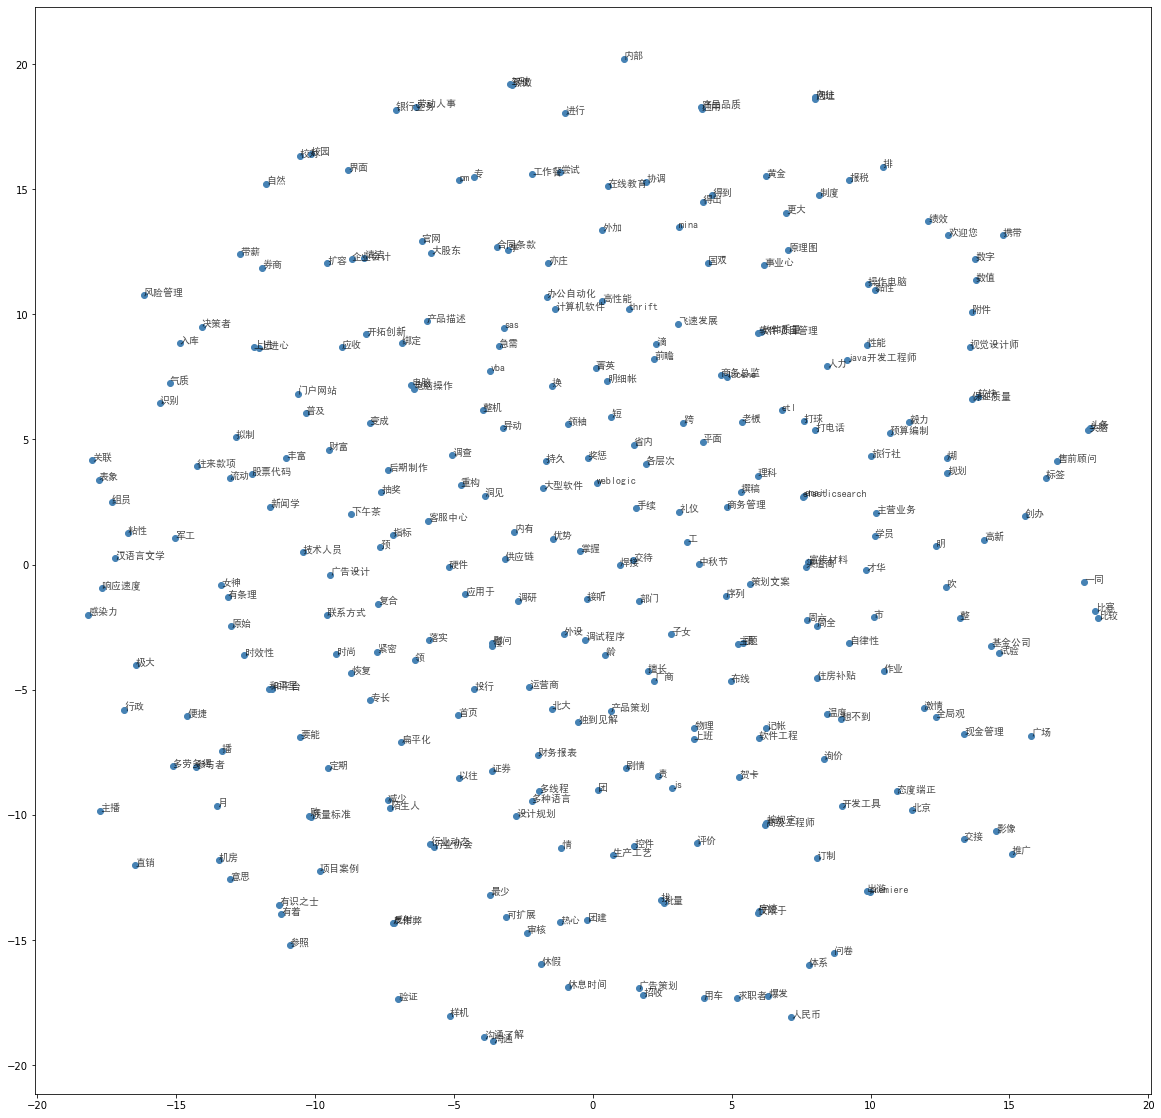

In [50]:
fig, ax = plt.subplots(figsize=(20, 20))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7,fontproperties=font)

In [46]:
fig.savefig('img.png')